In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf, ccf
from scipy.io import loadmat
import h5py

np.random.seed(2024)

# load data

In [3]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_nu2e-15_0305.mat'
with h5py.File(data_path, 'r') as file:
#     print("Keys: %s" % file.keys())
    psi1_hat_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_hat_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    params_dataset = file['params']
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = file['topo'][()]
print('psi_hat_t.shape',psi1_hat_t.shape)
psi1_hat_t = psi1_hat_t['real'] + 1j * psi1_hat_t['imag']
psi2_hat_t = psi2_hat_t['real'] + 1j * psi2_hat_t['imag']
print('psi_hat_t.dtype',psi1_hat_t.dtype)

psi_hat_t.shape (256, 256, 5000)
psi_hat_t.dtype complex128


# compute eigenvalues and eigenvectors

In [3]:
# compute eigenvalues and eigenvectors
omega1 = np.zeros((K,K), dtype=complex)
omega2 = np.zeros((K,K), dtype=complex)
r1 = np.zeros((K,K,2), dtype=complex)
r2 = np.zeros((K,K,2), dtype=complex)
beta_value = beta; kd_value = kd+0j; U_value = U;
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky):  
        k_mag = kx_value**2 + ky_value**2
        if k_mag == 0:  # Skip the case where k_mag is 0 to avoid division by zero
            continue

        # Compute omega_k1 and omega_k2
        omega_k2 = (kx_value * (beta_value * (kd_value**2 + 2 * k_mag) + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2))) / (2 * k_mag * (kd_value**2 + k_mag))
        omega_k1 = kx_value * (beta_value * (kd_value**2 + 2 * k_mag) - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (2 * k_mag * (kd_value**2 + k_mag))
        omega1[iky,ikx] = omega_k1; omega2[iky,ikx] = omega_k2

        # Compute r_k1 and r_k2
        r_k2 = np.array([
            [- (2 * U_value * k_mag**2 - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
            [1]
        ], dtype=complex)
        r_k1 = np.array([
            [- (2 * U_value * k_mag**2 + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
            [1]
        ], dtype=complex)
        r1[iky,ikx,:] = np.squeeze(r_k1); r2[iky,ikx,:] = np.squeeze(r_k2)


In [4]:
# save data
eigens = {
    'omega1': omega1,
    'omega2': omega2,
    'r1': r1,
    'r2': r2
}
np.save('../data/eigens_K256.npy', eigens)

In [5]:
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

# Calibration of OU Process

In [4]:
# load eigenvectors
eigens = np.load('../data/eigens_K256.npy', allow_pickle=True)
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']

In [6]:
# Model calibration using eigenmodes recovered based on eigenvectors
#The ansatz of the cross-correlation
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 4000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 16

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (ky_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

#         psi1_hat = (psi1_hat_t[ikx,iky,:] + psi2_hat_t[ikx,iky,:]) / 2 # This is a mistake. I should get the two eigenmode using r1 and r2
#         psi2_hat = (psi1_hat_t[ikx,iky,:] - psi2_hat_t[ikx,iky,:]) / 2
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
        acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
        acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
        ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
        ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(ACF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        m1 = np.mean(psi1_hat)
        E1 = np.var(psi1_hat)
        T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
        theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
        f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
        sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est; f_est[iky,ikx,0] = f1_est; sigma_est[iky,ikx,0] = sigma1_est;
        
        x2, _ = curve_fit(ACF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        m2 = np.mean(psi2_hat)
        E2 = np.var(psi2_hat)
        T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
        theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
        f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
        sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est; f_est[iky,ikx,1] = f2_est; sigma_est[iky,ikx,1] = sigma2_est;


/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


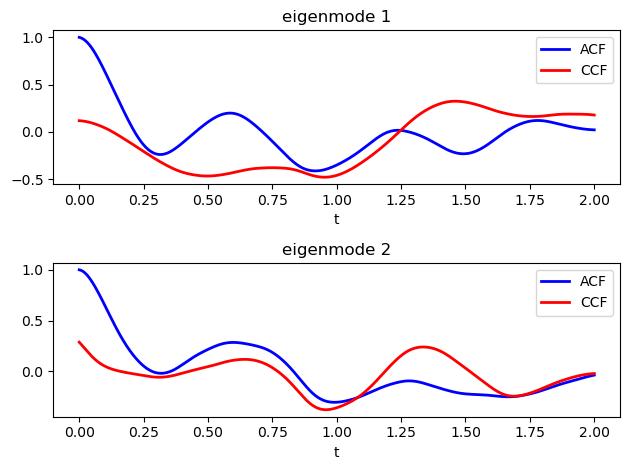

Estimated values:
gamma1, omega1, f1, sigma1
2.8171091276897737, -9.839563097167218, (-10740.05173324227+4635.253965325394j), 6659.921141448808
gamma2, omega2, f2, sigma2
6.115039569814445, 0.0010677547471070184, (-2487.7377912098223-3985.451485559499j), 21525.3168416192


In [7]:
# Showing the ACF and the cross-correlation
plt.subplot(2, 1, 1)
plt.plot(tt, acf_psi1, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi1, 'r', linewidth=2, label='CCF')
plt.title('eigenmode 1')
plt.legend()
plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(tt, acf_psi2, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi2, 'r', linewidth=2, label='CCF')
plt.title('eigenmode 2')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.show()

print('Estimated values:')
print(f'gamma1, omega1, f1, sigma1')
print(f'{gamma1_est}, {omega1_est}, {f1_est}, {sigma1_est}')
print(f'gamma2, omega2, f2, sigma2')
print(f'{gamma2_est}, {omega2_est}, {f2_est}, {sigma2_est}')

In [8]:
# save fitted parameters
est_params = {
    'gamma': gamma_est,
    'omega': omega_est,
    'f': f_est,
    'sigma': sigma_est,
    'cut': cut
}
np.save('../data/est_paras_ou_K256.npy', est_params)

In [9]:
np.where(gamma_est < 0)[0].shape

(0,)

### calibration using ccf

In [10]:
#The ansatz of the cross-correlation
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 4000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 16

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (ky_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

#         psi1_hat = (psi1_hat_t[ikx,iky,:] + psi2_hat_t[ikx,iky,:]) / 2 # This is a mistake. I should get the two eigenmode using r1 and r2
#         psi2_hat = (psi1_hat_t[ikx,iky,:] - psi2_hat_t[ikx,iky,:]) / 2
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
        acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
        acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
        ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
        ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(CCF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=8000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        m1 = np.mean(psi1_hat)
        E1 = np.var(psi1_hat)
        T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
        theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
        f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
        sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est; f_est[iky,ikx,0] = f1_est; sigma_est[iky,ikx,0] = sigma1_est;
        
        x2, _ = curve_fit(CCF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=8000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        m2 = np.mean(psi2_hat)
        E2 = np.var(psi2_hat)
        T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
        theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
        f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
        sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est; f_est[iky,ikx,1] = f2_est; sigma_est[iky,ikx,1] = sigma2_est;


/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_54706/509964511.py:48: RuntimeWarning: invalid value encountered in sqrt
  sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_54706/509964511.py:60: RuntimeWarning: invalid value encountered in sqrt
  sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 8000.

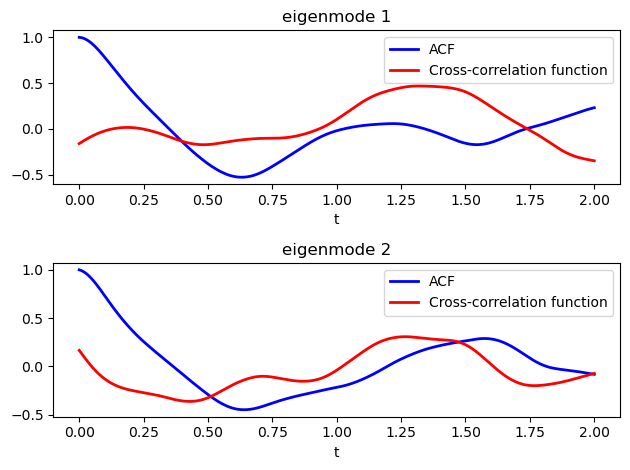

Estimated values:
gamma1, omega1, f1, sigma1
1.4890657599759607, -0.4986029074201958, (254.57131015262982-222.39058979067514j), 1393.2740845486946
gamma2, omega2, f2, sigma2
1.8331092217058504, -0.44164303347685235, (1.2592825324214436-155.43254185583868j), 4239.9250058653615


In [73]:
# Showing the ACF and the cross-correlation
plt.subplot(2, 1, 1)
plt.plot(tt, acf_psi1, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi1, 'r', linewidth=2, label='Cross-correlation function')
plt.title('eigenmode 1')
plt.legend()
plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(tt, acf_psi2, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi2, 'r', linewidth=2, label='Cross-correlation function')
plt.title('eigenmode 2')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.show()

print('Estimated values:')
print(f'gamma1, omega1, f1, sigma1')
print(f'{gamma1_est}, {omega1_est}, {f1_est}, {sigma1_est}')
print(f'gamma2, omega2, f2, sigma2')
print(f'{gamma2_est}, {omega2_est}, {f2_est}, {sigma2_est}')

In [74]:
np.where(gamma_est < 0)[0].shape

(2620,)

# Compare the eigenvalue to data-driven $\omega_{\mathbf{k}}$

In [11]:
# load parameters
params = np.load('../data/est_paras_ou_K256.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
eigens = np.load('../data/eigens_K256.npy', allow_pickle=True)
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']

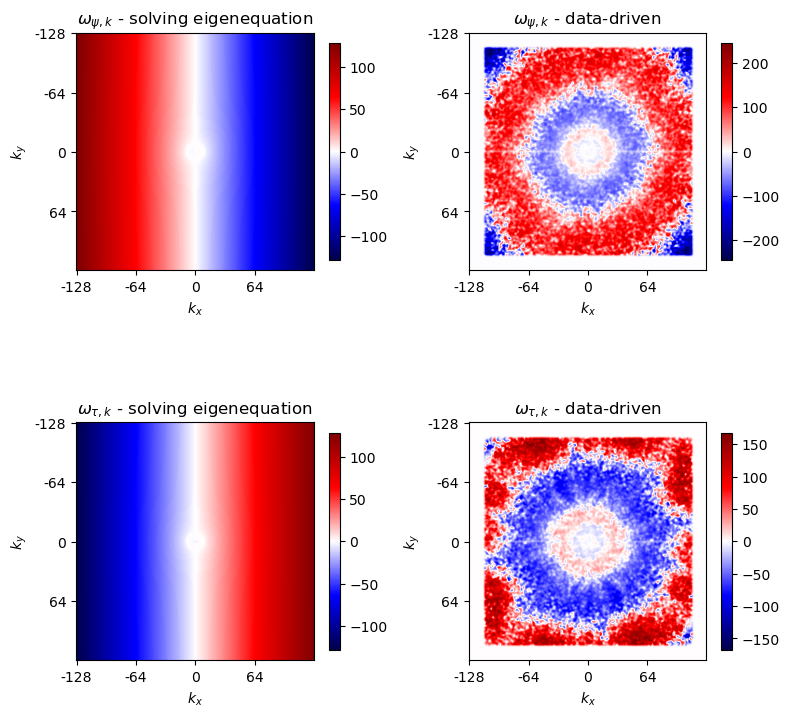

In [16]:
# plot omega
from scipy.ndimage import gaussian_filter

%matplotlib inline

matrix1 = omega1.real
matrix2 = omega[:,:,0]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

matrix3 = omega2.real
matrix4 = omega[:,:,1]
matrix3 = np.roll(matrix3, shift=K//2, axis=0)
matrix3 = np.roll(matrix3, shift=K//2, axis=1)
matrix4 = np.roll(matrix4, shift=K//2, axis=0) 
matrix4 = np.roll(matrix4, shift=K//2, axis=1)

# Generate grid indices for the KxK matrices
x = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
y = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
X, Y = np.meshgrid(x, y)
kx = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
ky = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
smoothed_matrix2 = gaussian_filter(matrix2, sigma=1)
smoothed_matrix4 = gaussian_filter(matrix4, sigma=1)

# Create a figure for the plots
fig = plt.figure(figsize=(8, 8))

itv = K//4
# Plot for matrix1
ax1 = fig.add_subplot(221)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-np.max(np.abs(matrix1)), vmax=np.max(np.abs(matrix1)))
ax1.set_title(r'$\omega_{\psi,k}$ - solving eigenequation')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::itv].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::itv].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax2 = fig.add_subplot(222)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(smoothed_matrix2, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix2)), vmax=np.max(np.abs(smoothed_matrix2)))
ax2.set_title(r'$\omega_{\psi,k}$ - data-driven')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::itv].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::itv].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

# Plot for matrix1
ax3 = fig.add_subplot(223)  # 1 row, 2 columns, 1st subplot
surf3 = ax3.imshow(matrix3, cmap='seismic', vmin=-np.max(np.abs(matrix3)), vmax=np.max(np.abs(matrix3)))
ax3.set_title(r'$\omega_{\tau,k}$ - solving eigenequation')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax3.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::itv].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::itv].astype(int))
fig.colorbar(surf3, shrink=0.6)#, ax=ax3, shrink=0.5, aspect=12)

# Plot for matrix2
ax4 = fig.add_subplot(224)  # 1 row, 2 columns, 2nd subplot
surf4 = ax4.imshow(smoothed_matrix4, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix4)), vmax=np.max(np.abs(smoothed_matrix4)))
ax4.set_title(r'$\omega_{\tau,k}$ - data-driven')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax4.set_zlabel('Value')
# ax4.set_zlim(-np.max(np.abs(smoothed_matrix4)), -np.max(np.abs(smoothed_matrix4)))
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::itv].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::itv].astype(int))
fig.colorbar(surf4, shrink=0.6)#, ax=ax4, shrink=0.5, aspect=12)

plt.tight_layout()
plt.savefig('./LSM/omega_compare_K256.png',dpi=150)
plt.show()

# Run the OU process model

In [17]:
# run ou process
# integration parameters
N = psi1_hat_t.shape[2]
dt = 0.0005
params = np.load('../data/est_paras_ou_K256.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']

# get the initial condition
psi_k = np.zeros((K, K, N), dtype=complex)
tau_k = np.zeros((K, K, N), dtype=complex)
# psi_k[:, :, 0] = (psi1_hat_t[:, :, 0] + psi2_hat_t[:, :, 0]) / 2
# tau_k[:, :, 0] = (psi1_hat_t[:, :, 0] - psi2_hat_t[:, :, 0]) / 2
for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (ky_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,0],psi2_hat_t[iky,ikx,0]])[:,None]
        psi_k[iky,ikx,0] = eigenmode[0] 
        tau_k[iky,ikx,0] = eigenmode[1] # psi_k always use 'xy' indexing

# # Numerical integration
# for ikx,kx_value in enumerate(kx):
#     for iky,ky_value in enumerate(ky):  
#         if (ky_value == 0 and ky_value==0) or kx_value==-K//2 or ky_value==-K//2: 
#             continue 
#         for i in range(1, N):
#             psi_k[ikx,iky,i] = psi_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * psi_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())
#             tau_k[ikx,iky,i] = tau_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * tau_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())

# Precompute constants
sqrt_dt = np.sqrt(dt)
noise_coeff = sigma/np.sqrt(2) * sqrt_dt
linear_coeff = (-gamma + 1j * omega) * dt
f_coeff = f * dt

# Conditions to skip
skip_indices = np.zeros((K, K), dtype=bool)
skip_indices[0, 0] = True
skip_indices[(K//2-cut):(K//2+cut+1), :] = True
skip_indices[:, (K//2-cut):(K//2+cut+1)] = True

for i in range(1, N):
    psi_k[:, :, i] = psi_k[:, :, i-1] + linear_coeff[:,:,0] * psi_k[:, :, i-1] + f_coeff[:,:,0] + noise_coeff[:,:,0] * (np.random.randn(K, K) + 1j * np.random.randn(K, K))
    tau_k[:, :, i] = tau_k[:, :, i-1] + linear_coeff[:,:,1] * tau_k[:, :, i-1] + f_coeff[:,:,1] + noise_coeff[:,:,1] * (np.random.randn(K, K) + 1j * np.random.randn(K, K))
    
    # Apply conditions to skip
    psi_k[skip_indices, i] = psi_k[skip_indices, i-1]
    tau_k[skip_indices, i] = tau_k[skip_indices, i-1]

In [18]:
# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'dt': dt
}
np.savez('../data/ou_run_K256.npz', **ou_run)

# Evaluation

In [5]:
# load data
ou_run = np.load('../data/ou_run_K256.npz')
ou_run.files

['psi_k', 'tau_k', 'N', 'dt']

In [7]:
# ifft to real space
# truncate Fourier modes
cut = 16

# truth
N = ou_run['N']
psi_k = ou_run['psi_k'] 
psi_t_k = np.zeros((K,K,N), dtype='complex')
psi_ifft = np.zeros((K,K,N))
psi_t_ifft = np.zeros((K,K,N))
tau_k = ou_run['tau_k']
tau_t_k = np.zeros((K,K,N), dtype='complex')
tau_ifft = np.zeros((K,K,N))
tau_t_ifft = np.zeros((K,K,N))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K

for ikx,kx_value in enumerate(kx):
    print(ikx)
    for iky,ky_value in enumerate(ky): 
        if (ky_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi_t_k[iky,ikx,:] = eigenmode[0,:] 
        tau_t_k[iky,ikx,:] = eigenmode[1,:] # psi_k always use 'xy' indexing


psi_k[K//2-cut:K//2+cut+1,K//2-cut:K//2+cut+1,:] = 0
tau_k[K//2-cut:K//2+cut+1,K//2-cut:K//2+cut+1,:] = 0

# for i in range(N):
#     psi_ifft[:,:,i] = np.fft.ifft2(psi_k[:, :, i])
#     tau_ifft[:,:,i] = np.fft.ifft2(tau_k[:, :, i])
#     psi_t_ifft[:,:,i] = np.fft.ifft2(psi_t_k[:, :, i])
#     tau_t_ifft[:,:,i] = np.fft.ifft2(tau_t_k[:, :, i])

# psi_ifft = np.roll(psi_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# psi_ifft = np.roll(psi_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# tau_ifft = np.roll(tau_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# tau_ifft = np.roll(tau_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# psi_t_ifft = np.roll(psi_t_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# psi_t_ifft = np.roll(psi_t_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# tau_t_ifft = np.roll(tau_t_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# tau_t_ifft = np.roll(tau_t_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [58]:
# save data
psi_ou_truth = {
    'psi_ifft': psi_ifft,
    'psi_t_ifft': psi_t_ifft,
    'tau_ifft': tau_ifft,
    'tau_t_ifft': tau_t_ifft,
    'N': N,
    'cut': cut
}
np.savez('../data/psi_ou_truth_K128.npz', **psi_ou_truth)

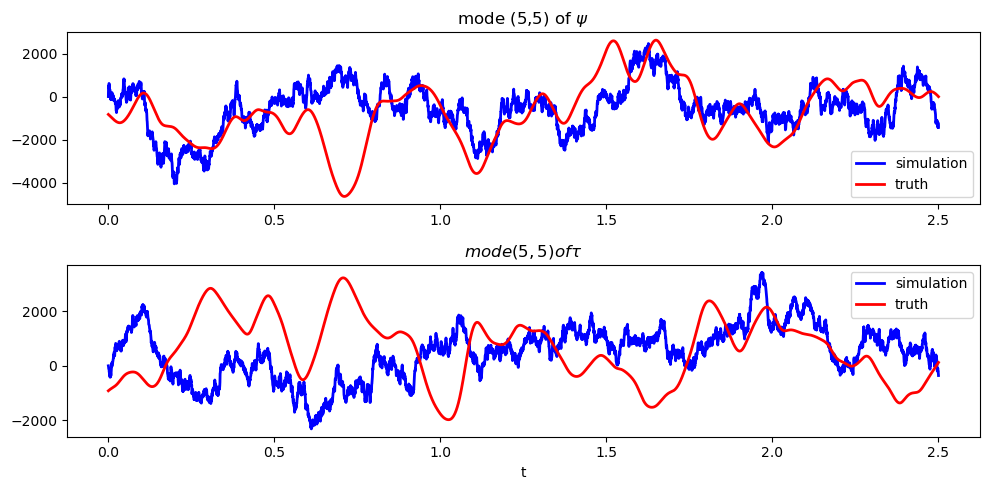

In [8]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_k[mode,mode,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_t_k[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title('mode (5,5) of $\psi$')
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_k[mode,mode,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_t_k[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$mode (5,5) of  \tau$')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.savefig('./LSM/psi_k_ou_truth_K256.png', dpi=100)
plt.show()

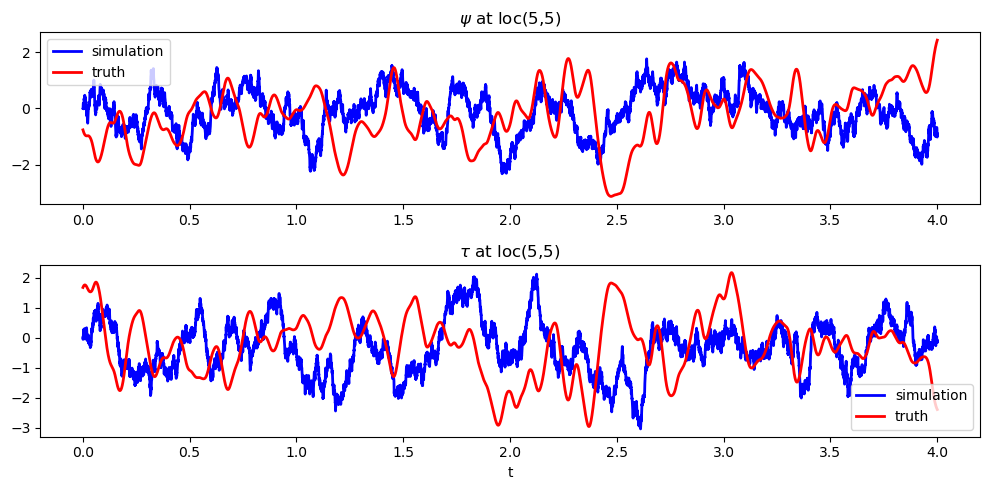

In [61]:
# Plotting trajectories
%matplotlib inline

loc = 5
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_ifft[loc,loc,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_t_ifft[loc,loc,:]), 'r', linewidth=2, label='truth')
plt.title('$\psi$ at loc(5,5)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_ifft[loc,loc,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_t_ifft[loc,loc,:]), 'r', linewidth=2, label='truth')
plt.title(r'$\tau$ at loc(5,5)' )
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.savefig('./LSM/psi_ou_truth_K256.png', dpi=100)
plt.show()


In [9]:
# energy spectrum
def ene_spectrum(psi_hat, K, kd, topo):
    hk = np.fft.fft2(topo)
    K_half = K // 2
    KE = np.zeros(K_half + 1)
    APE = np.zeros_like(KE)
    E = np.zeros_like(KE)
    ETP = np.zeros_like(KE)
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    
    DY_psi_hat = psi_hat * (1j) * KY[:,:,None]
    DX_psi_hat = psi_hat * (1j) * KX[:,:,None]
    Laplacian = ((1j) * KY)**2 + ((1j) * KX)**2
    q_hat = np.zeros((K,K,2), dtype=complex)
    q_hat[:,:,0] = Laplacian * psi_hat[:,:,0] + kd**2/2*(psi_hat[:,:,1]-psi_hat[:,:,0])
    q_hat[:,:,1] = Laplacian * psi_hat[:,:,1] + kd**2/2*(psi_hat[:,:,0]-psi_hat[:,:,1]) + hk
    
    for jj in range(K):
        for ii in range(K):
            k = np.sqrt(KX[ii, jj]**2 + KY[ii, jj]**2)
            if np.ceil(k) <= K_half:
                r = k - np.floor(k)
                floor_k = int(np.floor(k))
                ceil_k = int(np.ceil(k))

                KE[floor_k] += (1 - r) * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                APE[floor_k] += (1 - r) * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                E[floor_k] += (1 - r) * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                ETP[floor_k] += (1 - r) * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)

                if ceil_k != floor_k:  # Only update if ceil(k) and floor(k) are different
                    KE[ceil_k] += r * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                    APE[ceil_k] += r * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                    E[ceil_k] += r * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                    ETP[ceil_k] += r * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)

    KE = .5 * KE / (K**4)
    APE = .5 * APE / (K**4)
    E = .5 * E / (K**4)
    ETP = .5 * ETP / (K**4)
    
    return KE, APE, E, ETP
    

t_avrg = 100
psi_hat_t = np.concatenate((psi1_hat_t[:,:,None,-t_avrg:], psi2_hat_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp = ene_spectrum(psi_hat_t[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp = ene_spectrum(psi_hat_t[:,:,:,-i], K, kd, topo)
    ke += ike
    ape += iape
    ene += iene
    etp += ietp 

ke = ke / t_avrg
ape = ape / t_avrg
ene = ene / t_avrg
etp = etp / t_avrg

psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou = ene_spectrum(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp = ene_spectrum(psi_hat[:,:,:,-i], K, kd, topo)
    ke_ou += ike
    ape_ou += iape
    ene_ou += iene
    etp_ou += ietp 

ke_ou = ke_ou / t_avrg
ape_ou = ape_ou / t_avrg
ene_ou = ene_ou / t_avrg
etp_ou = etp_ou / t_avrg

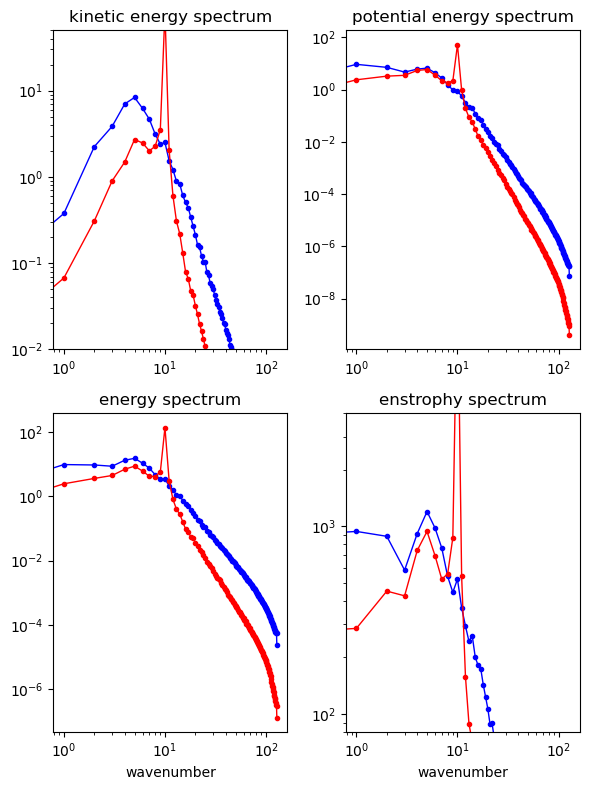

In [10]:
# spectrum of truth
plt.figure(2, figsize=(6, 8))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 2, 1)
plt.loglog(np.arange(0, K//2 + 1), ke, '.-b', linewidth=1)
plt.loglog(np.arange(0, K//2 + 1), ke_ou, '.-r', linewidth=1)
plt.ylim([1e-2, 50])
plt.title('kinetic energy spectrum')
# plt.xlabel('wavenumber')
plt.subplot(2, 2, 2)
plt.loglog(np.arange(0, K//2 + 1), ape, '.-b', linewidth=1)
plt.loglog(np.arange(0, K//2 + 1), ape_ou, '.-r', linewidth=1)
plt.title('potential energy spectrum')
# plt.xlabel('wavenumber')
# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('energy_topo10_nu2e-15_0228.png', dpi=150)  # Save the figure

# Figure 2
# plt.figure(3, figsize=(6, 4))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 2, 3)
plt.loglog(np.arange(0, K//2 + 1), ene, '.-b', linewidth=1)
plt.loglog(np.arange(0, K//2 + 1), ene_ou, '.-r', linewidth=1)
plt.title('energy spectrum')
plt.xlabel('wavenumber')
plt.subplot(2, 2, 4)
plt.loglog(np.arange(0, K//2 + 1), etp, '.-b', linewidth=1)
plt.loglog(np.arange(0, K//2 + 1), etp_ou, '.-r', linewidth=1)
plt.ylim([80, 4000])
plt.title('enstrophy spectrum')
plt.xlabel('wavenumber')
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('./LSM/spectrum_K256.png', dpi=150)  # Save the figure
plt.show()

In [11]:
np.where(ke_ou==np.max(ke_ou))

(array([10]),)

In [14]:
params = np.load('../data/est_paras_ou_K256.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']

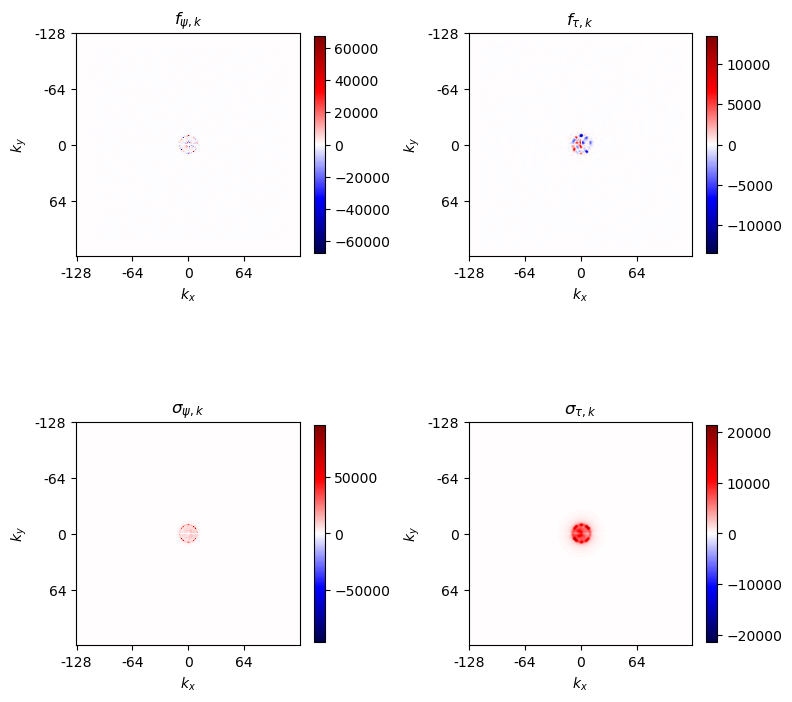

In [16]:
# plot omega
from scipy.ndimage import gaussian_filter

%matplotlib inline

matrix1 = f[:,:,0].real
matrix2 = f[:,:,1].real
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

matrix3 = sigma[:,:,0]
matrix4 = sigma[:,:,1]
matrix3 = np.roll(matrix3, shift=K//2, axis=0)
matrix3 = np.roll(matrix3, shift=K//2, axis=1)
matrix4 = np.roll(matrix4, shift=K//2, axis=0) 
matrix4 = np.roll(matrix4, shift=K//2, axis=1)

# Generate grid indices for the KxK matrices
x = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
y = np.linspace(0, K, num=K, endpoint=False) #np.fft.fftfreq(K) * K
X, Y = np.meshgrid(x, y)
kx = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
ky = np.roll(np.fft.fftfreq(K) * K, shift=K//2)
smoothed_matrix2 = gaussian_filter(matrix2, sigma=1)
smoothed_matrix4 = gaussian_filter(matrix4, sigma=1)

# Create a figure for the plots
fig = plt.figure(figsize=(8, 8))

# Plot for matrix1
ax1 = fig.add_subplot(221)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-np.max(np.abs(matrix1)), vmax=np.max(np.abs(matrix1)))
ax1.set_title(r'$f_{\psi,k}$')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::64].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::64].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax2 = fig.add_subplot(222)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(smoothed_matrix2, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix2)), vmax=np.max(np.abs(smoothed_matrix2)))
ax2.set_title(r'$f_{\tau,k}$')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::64].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::64].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

# Plot for matrix1
ax3 = fig.add_subplot(223)  # 1 row, 2 columns, 1st subplot
surf3 = ax3.imshow(matrix3, cmap='seismic', vmin=-np.max(np.abs(matrix3)), vmax=np.max(np.abs(matrix3)))
ax3.set_title(r'$\sigma_{\psi,k}$')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax3.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::64].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::64].astype(int))
fig.colorbar(surf3, shrink=0.6)#, ax=ax3, shrink=0.5, aspect=12)

# Plot for matrix2
ax4 = fig.add_subplot(224)  # 1 row, 2 columns, 2nd subplot
surf4 = ax4.imshow(smoothed_matrix4, cmap='seismic', vmin=-np.max(np.abs(smoothed_matrix4)), vmax=np.max(np.abs(smoothed_matrix4)))
ax4.set_title(r'$\sigma_{\tau,k}$')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax4.set_zlabel('Value')
# ax4.set_zlim(-np.max(np.abs(smoothed_matrix4)), -np.max(np.abs(smoothed_matrix4)))
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::64].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::64].astype(int))
fig.colorbar(surf4, shrink=0.6)#, ax=ax4, shrink=0.5, aspect=12)

plt.tight_layout()
# plt.savefig('./LSM/omega_compare.png',dpi=150)
plt.show()

# solving eigenequation

In [52]:
import sympy as sp
from sympy import symbols, sqrt, simplify, factor

# Define symbolic variables
kx, ky, kd, U, beta = sp.symbols('k_x k_y k_d U beta')
k_mag = kx**2 + ky**2  # Magnitude of the wavevector k

# Define the matrices A_k and B_k
A_k = sp.Matrix([
    [-(k_mag + kd/2), kd/2],
    [kd/2, -(k_mag + kd/2)]
])

B_k = kx * sp.Matrix([
    [beta - k_mag * U + kd/2 * U, kd/2 * U],
    [-kd/2 * U, beta + k_mag * U - kd/2 * U]
])

# Compute C_k = -A_k.inv() * B_k
C_k = -A_k.inv() * B_k


In [48]:
A_k

Matrix([
[-k_d/2 - k_x**2 - k_y**2,                    k_d/2],
[                   k_d/2, -k_d/2 - k_x**2 - k_y**2]])

In [49]:
B_k

Matrix([
[k_x*(U*k_d/2 - U*(k_x**2 + k_y**2) + beta),                                 U*k_d*k_x/2],
[                              -U*k_d*k_x/2, k_x*(-U*k_d/2 + U*(k_x**2 + k_y**2) + beta)]])

In [50]:
# Solve the eigenvalue problem for C_k
eigenvals = C_k.eigenvals()
eigenvects = C_k.eigenvects()

print("Eigenvalues (omega_k):", eigenvals)
print("Eigenvectors (r_k):", eigenvects)


Eigenvalues (omega_k): {beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) - k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2)/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4)): 1, beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) + k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2)/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4)): 1}
Eigenvectors (r_k): [(beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) - k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4

In [60]:
eigenvalue1 = beta * kx * (kd + 2*kx**2 + 2*ky**2) / (2*(kx**2 + ky**2)*(kd + kx**2 + ky**2)) - kx * sqrt(-4*U**2*kd**2*kx**4 - 8*U**2*kd**2*kx**2*ky**2 - 4*U**2*kd**2*ky**4 + 4*U**2*kx**8 + 16*U**2*kx**6*ky**2 + 24*U**2*kx**4*ky**4 + 16*U**2*kx**2*ky**6 + 4*U**2*ky**8 + beta**2*kd**2) / (2*(kd*kx**2 + kd*ky**2 + kx**4 + 2*kx**2*ky**2 + ky**4))
eigenvalue2 = beta * kx * (kd + 2*kx**2 + 2*ky**2) / (2*(kx**2 + ky**2)*(kd + kx**2 + ky**2)) + kx * sqrt(-4*U**2*kd**2*kx**4 - 8*U**2*kd**2*kx**2*ky**2 - 4*U**2*kd**2*ky**4 + 4*U**2*kx**8 + 16*U**2*kx**6*ky**2 + 24*U**2*kx**4*ky**4 + 16*U**2*kx**2*ky**6 + 4*U**2*ky**8 + beta**2*kd**2) / (2*(kd*kx**2 + kd*ky**2 + kx**4 + 2*kx**2*ky**2 + ky**4))

# Simplify the eigenvalues
simplified_eigenvalue1 = simplify(eigenvalue1)
simplified_eigenvalue2 = simplify(eigenvalue2)

# Optionally, factor the eigenvalues
factored_eigenvalue1 = factor(simplified_eigenvalue1)
factored_eigenvalue2 = factor(simplified_eigenvalue2)

# Output the simplified and factored eigenvalues
print("Simplified Eigenvalue 1:", simplified_eigenvalue1)
print("Simplified Eigenvalue 2:", simplified_eigenvalue2)
print("Factored Eigenvalue 1:", factored_eigenvalue1)
print("Factored Eigenvalue 2:", factored_eigenvalue2)

Simplified Eigenvalue 1: k_x*(beta*k_d + 2*beta*k_x**2 + 2*beta*k_y**2 - sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2))/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4))
Simplified Eigenvalue 2: k_x*(beta*k_d + 2*beta*k_x**2 + 2*beta*k_y**2 + sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2))/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4))
Factored Eigenvalue 1: k_x*(beta*k_d + 2*beta*k_x**2 + 2*beta*k_y**2 - sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2))/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**

In [59]:
eigenvals.keys()

dict_keys([beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) - k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2)/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4)), beta*k_x*(k_d + 2*k_x**2 + 2*k_y**2)/(2*(k_x**2 + k_y**2)*(k_d + k_x**2 + k_y**2)) + k_x*sqrt(-4*U**2*k_d**2*k_x**4 - 8*U**2*k_d**2*k_x**2*k_y**2 - 4*U**2*k_d**2*k_y**4 + 4*U**2*k_x**8 + 16*U**2*k_x**6*k_y**2 + 24*U**2*k_x**4*k_y**4 + 16*U**2*k_x**2*k_y**6 + 4*U**2*k_y**8 + beta**2*k_d**2)/(2*(k_d*k_x**2 + k_d*k_y**2 + k_x**4 + 2*k_x**2*k_y**2 + k_y**4))])

### Verify that symbolic results are correct by pluggin real numbers

In [116]:
# built-in function
import numpy as np

# Assign real numbers to the variables
kx_value = 1.0  # Example value for kx
ky_value = 1.0  # Example value for ky
kd_value = 0.5  # Example value for kd
U_value = 2.0   # Example value for U
beta_value = 1.0  # Example value for beta

# Calculate k_mag
k_mag = kx_value**2 + ky_value**2

# Define the matrices A_k and B_k
A_k = np.array([
    [-(k_mag + kd_value**2/2), kd_value**2/2],
    [kd_value**2/2, -(k_mag + kd_value**2/2)]
])

B_k = kx_value * np.array([
    [beta_value - k_mag * U_value + kd_value**2/2 * U_value, kd_value**2/2 * U_value],
    [-kd_value**2/2 * U_value, beta_value + k_mag * U_value - kd_value**2/2 * U_value]
])

# Compute C_k = -np.linalg.inv(A_k) @ B_k
C_k = -np.linalg.inv(A_k) @ B_k

# Solve the eigenvalue problem
eigenvalues, eigenvectors = np.linalg.eig(C_k)

# Print the results
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors[:,0],eigenvectors[:,1])


Eigenvalues: [-1.2918307   2.23627515]
Eigenvectors: [-0.99849642 -0.05481687] [-0.07040978 -0.99751815]


In [117]:
print(eigenvalues[0] * eigenvectors[:,0])
print(C_k @ eigenvectors[:,0][:, None])

[1.28988834 0.07081412]
[[1.28988834]
 [0.07081412]]


In [113]:
# Compute omega_k1 and omega_k2 using the symbolic formula
omega_k2 = (kx_value * (beta_value * (kd_value**2 + 2 * k_mag) + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2))) / (2 * k_mag * (kd_value**2 + k_mag))
omega_k1 = kx_value * (beta_value * (kd_value**2 + 2 * k_mag) - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (2 * k_mag * (kd_value**2 + k_mag))

# Compute r_k1 and r_k2
r_k2 = np.array([
    [- (2 * U_value * k_mag**2 - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
    [1]
])

r_k1 = np.array([
    [- (2 * U_value * k_mag**2 + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
    [1]
])

r_k1 = r_k1.T[0] / np.linalg.norm(r_k1.T[0])
r_k2 = r_k2.T[0] / np.linalg.norm(r_k2.T[0])

# Print the results
print("Omega_k1:", omega_k1)
print("Omega_k2:", omega_k2)
print("Eigenvector r_k1:", r_k1)  # Transposed for display purposes
print("Eigenvector r_k2:", r_k2)  # Transposed for display purposes

Omega_k1: -1.2918307010341588
Omega_k2: 2.236275145478603
Eigenvector r_k1: [0.99849642 0.05481687]
Eigenvector r_k2: [0.07040978 0.99751815]


In [114]:
omega_k1 * r_k1

array([-1.28988834, -0.07081412])

In [115]:
C_k @ r_k1#[:,None]

array([-1.28988834, -0.07081412])

# Cropped Fourier modes in IFFT

In [65]:
# Define N again and other variables needed for the corrected manual IFFT computation
N = 50  # Redefining N as it was not defined in this code block
x = np.linspace(-np.pi, np.pi, N, endpoint=False)  # Spatial domain
x2 = np.linspace(0, 2*np.pi, 50, endpoint=False)
kk = np.fft.fftfreq(N) * N  # Frequency bins normalized by N

# Assuming ifx is already defined correctly from a previous operation, but let's redefine it for this block
fx = np.sin(x) + np.sin(3*x) + np.cos(x) + np.cos(2*x) + x**2 + np.sin(x**2)
ifx = np.fft.fft(fx)

cut = 5
ifx[25-cut:25+cut] = 0

# Corrected manual IFFT computation
fx_manual_corrected = ifx[None,:] @ np.exp(1j * kk[:,None] * x2[None, :]) / 50

# Verify the corrected manual calculation
fx_manual_corrected_real = fx_manual_corrected.real  # Considering the real part for comparison

# Comparison
difference_corrected = np.abs(fx - fx_manual_corrected_real)
max_difference_corrected = np.max(difference_corrected)
are_close_corrected = np.allclose(fx, fx_manual_corrected_real, atol=1e-10)

max_difference_corrected, are_close_corrected


(0.002997363495676808, False)

In [70]:
cut = 5
ifx[25-cut:25+cut] = 0
ifxc = np.concatenate([ifx[:25-cut], ifx[25+cut:]])
kkc =  np.concatenate([kk[:25-cut], kk[25+cut:]])

# Corrected manual IFFT computation
fx_manual_corrected = ifxc[None,:] @ np.exp(1j * kkc[:,None] * x2[None, :]) / (50-cut*2)

# Verify the corrected manual calculation
fx_manual_corrected_real = fx_manual_corrected.real  # Considering the real part for comparison

# Comparison
difference_corrected = np.abs(fx - fx_manual_corrected_real)
max_difference_corrected = np.max(difference_corrected)
are_close_corrected = np.allclose(fx, fx_manual_corrected_real, atol=1e-10)

max_difference_corrected, are_close_corrected


(2.5151535009876262, False)